<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/kitti_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset: We are downloading only 4 video sequences for this experiment<br>
Src: https://www.cvlibs.net/datasets/kitti/raw_data.php?type=city

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0017/2011_09_26_drive_0017_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0048/2011_09_26_drive_0048_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0060/2011_09_26_drive_0060_sync.zip

--2022-10-24 22:20:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.60
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424412944 (405M) [application/zip]
Saving to: ‘2011_09_28_drive_0001_sync.zip’

2011_09_28_drive_00 100%[===================>] 404.75M  14.0MB/s    in 30s     

2022-10-24 22:20:42 (13.6 MB/s) - ‘2011_09_28_drive_0001_sync.zip’ saved [424412944/424412944]

--2022-10-24 22:20:42--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0017/2011_09_26_drive_0017_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.99
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.99|:443... connected.
HTTP request sent, await

Unzip the data and organize all the video sequences into the new directory 'kitti_raw/data' 

In [2]:
!mkdir kitti_raw
!mkdir kitti_raw/data
!unzip -q 2011_09_28_drive_0001_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0017_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0048_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0060_sync.zip -d kitti_raw

!mkdir kitti_raw/data
!mv kitti_raw/2011_09_26/*  kitti_raw/data
!mv kitti_raw/2011_09_28/*  kitti_raw/data

!rm -rf kitti_raw/2011_09_26
!rm -rf kitti_raw/2011_09_28

mkdir: cannot create directory ‘kitti_raw/data’: File exists


Installations:

In [3]:
!pip -q install torchmetrics

     |████████████████████████████████| 529 kB 36.2 MB/s 


Arguments:

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=20, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

Create Dataloader:

Sample size- Train:264, Valid: 360
input: torch.Size([6, 128, 384]) label: torch.Size([3, 128, 384])


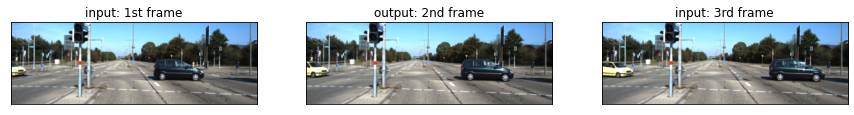

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

class Kitti_dataset(Dataset):

    def __init__(self, root=None, sequences=None, transform=None):
        self.transform = transform
        self.triplet_dirs_all = []
        for seq in sequences:
            for mono_folder in ['image_02', 'image_03']:
                full_dir = os.path.join(root, seq, mono_folder, 'data/*.png')
                sorted_dirs = sorted(glob(full_dir))
                for idx in range(len(sorted_dirs[:-2])):
                    triplet_dirs = [sorted_dirs[idx], sorted_dirs[idx + 1], sorted_dirs[idx + 2]]
                    self.triplet_dirs_all.append(triplet_dirs)

    def __len__(self):
        return len(self.triplet_dirs_all)

    def __getitem__(self, index):
        img1 = Image.open(self.triplet_dirs_all[index][0]).convert('RGB')
        img2 = Image.open(self.triplet_dirs_all[index][1]).convert('RGB')
        img3 = Image.open(self.triplet_dirs_all[index][2]).convert('RGB')
        if self.transform:
            img1, img2, img3 = self.transform(img1), self.transform(img2), self.transform(img3)
        input = torch.concat([img1, img3])
        return input, img2


transform_all = transforms.Compose([
    transforms.Resize((128, 384)),
    transforms.ToTensor(),
])

args = get_args()
root = 'kitti_raw/data'
sequences_train = ['2011_09_26_drive_0017_sync', '2011_09_26_drive_0048_sync']
sequences_valid = ['2011_09_28_drive_0001_sync', '2011_09_26_drive_0060_sync']

train_dataset = Kitti_dataset(root=root, sequences=sequences_train, transform=transform_all)
valid_dataset = Kitti_dataset(root=root, sequences=sequences_valid, transform=transform_all)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
train_loader = DataLoader(valid_dataset, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

print("Sample size- Train:%d, Valid: %d"%(len(train_dataset), len(valid_dataset)))

(input, label) = train_dataset[0]
print('input:', input.shape, 'label:', label.shape)
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))
ax[0].set_title('input: 1st frame')

ax[1].imshow(label.permute(1,2,0))
ax[1].set_title('output: 2nd frame')

ax[2].imshow(input[3:].permute(1,2,0))
ax[2].set_title('input: 3rd frame');

Loss functions:

In [13]:
import torch
import math
import torch.nn.functional as F
import numpy as np
from torch import nn
from torchmetrics import StructuralSimilarityIndexMeasure

class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)

Training:

In [14]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import StructuralSimilarityIndexMeasure
import torchvision.transforms as transforms
from PIL import Image
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model, trainloader, optimizer, criterion):
    model.train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            outputs = model(image_batch)
            #outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
        return np.mean(mse_all), np.mean(ssim_all)

def main():
    seed_everything()
    args = get_args()

    root = 'kitti_raw/data'
    sequences_train = ['2011_09_26_drive_0017_sync', '2011_09_26_drive_0048_sync']
    sequences_valid = ['2011_09_28_drive_0001_sync', '2011_09_26_drive_0060_sync']

    train_dataset = Kitti_dataset(root=root, sequences=sequences_train, transform=transform_all)
    valid_dataset = Kitti_dataset(root=root, sequences=sequences_valid, transform=transform_all)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(train_dataset), len(valid_dataset)))
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=6, out_channels=3, init_features=32, pretrained=False)
    # model.encoder1.enc1conv1 = nn.Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    # model.conv = nn.Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    model.to(device)

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)

    
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.BCELoss().to(device)
    best_mse, best_ssim, best_epoch = np.inf, 0, 0
    for epoch_num in range(args.max_epochs):
        train(model, train_loader, optimizer, criterion)
        mse, ssim = test(model, valid_loader)
        if mse < best_mse:
            best_mse = mse
            best_ssim = ssim
            best_epoch = epoch_num
            torch.save(model.state_dict(), args.ckpt)
            
        print('Epoch:{}, Curr MSE(L2):{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))

if __name__ == "__main__":
    main()

Sample size- Train:264, Valid: 360


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Epoch:0, Curr MSE:0.113184, Best MSE:0.113184, Best SSIM:0.258054, Best Epoch:0, Criterion:bce, Lr:0.001
Epoch:1, Curr MSE:0.088878, Best MSE:0.088878, Best SSIM:0.310998, Best Epoch:1, Criterion:bce, Lr:0.001
Epoch:2, Curr MSE:0.057517, Best MSE:0.057517, Best SSIM:0.388468, Best Epoch:2, Criterion:bce, Lr:0.001
Epoch:3, Curr MSE:0.040108, Best MSE:0.040108, Best SSIM:0.446505, Best Epoch:3, Criterion:bce, Lr:0.001
Epoch:4, Curr MSE:0.028056, Best MSE:0.028056, Best SSIM:0.508030, Best Epoch:4, Criterion:bce, Lr:0.001
Epoch:5, Curr MSE:0.020137, Best MSE:0.020137, Best SSIM:0.564342, Best Epoch:5, Criterion:bce, Lr:0.001
Epoch:6, Curr MSE:0.015749, Best MSE:0.015749, Best SSIM:0.594852, Best Epoch:6, Criterion:bce, Lr:0.001
Epoch:7, Curr MSE:0.014048, Best MSE:0.014048, Best SSIM:0.619393, Best Epoch:7, Criterion:bce, Lr:0.001
Epoch:8, Curr MSE:0.011134, Best MSE:0.011134, Best SSIM:0.645480, Best Epoch:8, Criterion:bce, Lr:0.001
Epoch:9, Curr MSE:0.011951, Best MSE:0.011134, Best SSI

Qualitative Performance:

In [15]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=6, out_channels=3, init_features=32, pretrained=False)
model.load_state_dict(torch.load('best_model.pth.tar'))


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

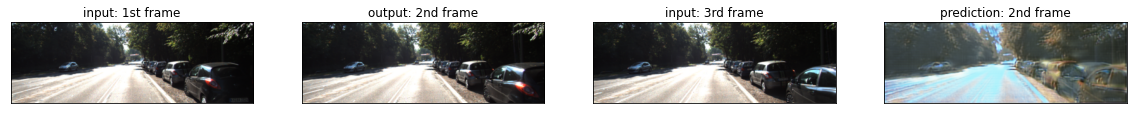

In [34]:
(input, label) = valid_dataset[100]
prediction = model(input[None])

num_img = 4
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))
ax[0].set_title('input: 1st frame')

ax[1].imshow(label.permute(1,2,0))
ax[1].set_title('output: 2nd frame')

ax[2].imshow(input[3:].permute(1,2,0))
ax[2].set_title('input: 3rd frame');

ax[3].imshow(prediction[0].detach().cpu().permute(1,2,0))
ax[3].set_title('prediction: 2nd frame');